# Ekinox Data Science Test    

# Candidat:  
- **Zoumana KEITA**   
    - Data Scientist @Axionable     
    - zoumana.keita@hotmail.com | [Medium Blog](https://medium.com/@zoumanakeita) | [LinkedIn](https://www.linkedin.com/in/zoumana-keita/) | Mob: +33 751 410 637

## Problème Général   
Face à la chute du niveau scolaire constaté à la suite de la fermeture des écoles, le *Ministério da Educação (*Ministère de l'Éducation portugais) vous contacte, avec l'idée d'utiliser "l'Intelligence Artificielle" pour tenter de remédier à la situation.
Le Ministère souhaiterait disposer d'un outil qui permettrait de fournir des conseils personnalisés à transmettre à chaque étudiant·e en vue d'améliorer son niveau scolaire. Cet outil devra aussi permettre au personnel d'établissement de prioriser ces actions de conseil et d'accompagnement en fonction de leur impact potentiel et du niveau scolaire actuel des étudiants concernés.

Votre mission, si vous l'acceptez, est de démontrer à la personne en charge de ce projet la faisabilité et l'intérêt (ou non) d'utiliser le Machine Learning pour ce cas d'usage ; ainsi que d'être prêt·e, au cas où il y aurait effectivement un intérêt, à développer très rapidement une première application pouvant être utilisée par deux écoles pilotes.

Afin de vous aider dans cette tâche, vous pourrez vous appuyer sur les résultats scolaires en mathématiques et en portugais des étudiants de deux écoles pilotes, ainsi que sur les réponses à un questionnaire qui leur a été transmis préalablement.      

# Compréhension du besoin     
L'objectif de ce projet est de munir le Ministère d'une solution analytique afin de permettre un meilleur suivi du niveau académique des élève et par conséquent adopter les actions nécéssaires.       
- Ce projet est faisable, car nous avons des données historiques propres au problème que l'on cherche à resoudre.     
- Il aura également un grand intérêt, car il facilitera le processus d'amélioration du niveau scolaire des élèves, et cela de manière efficace.   

Vous trouverez ci-dessous l'architecture globale de la mise en place de la solution, de la collecte des données à la création de la solution finale.    

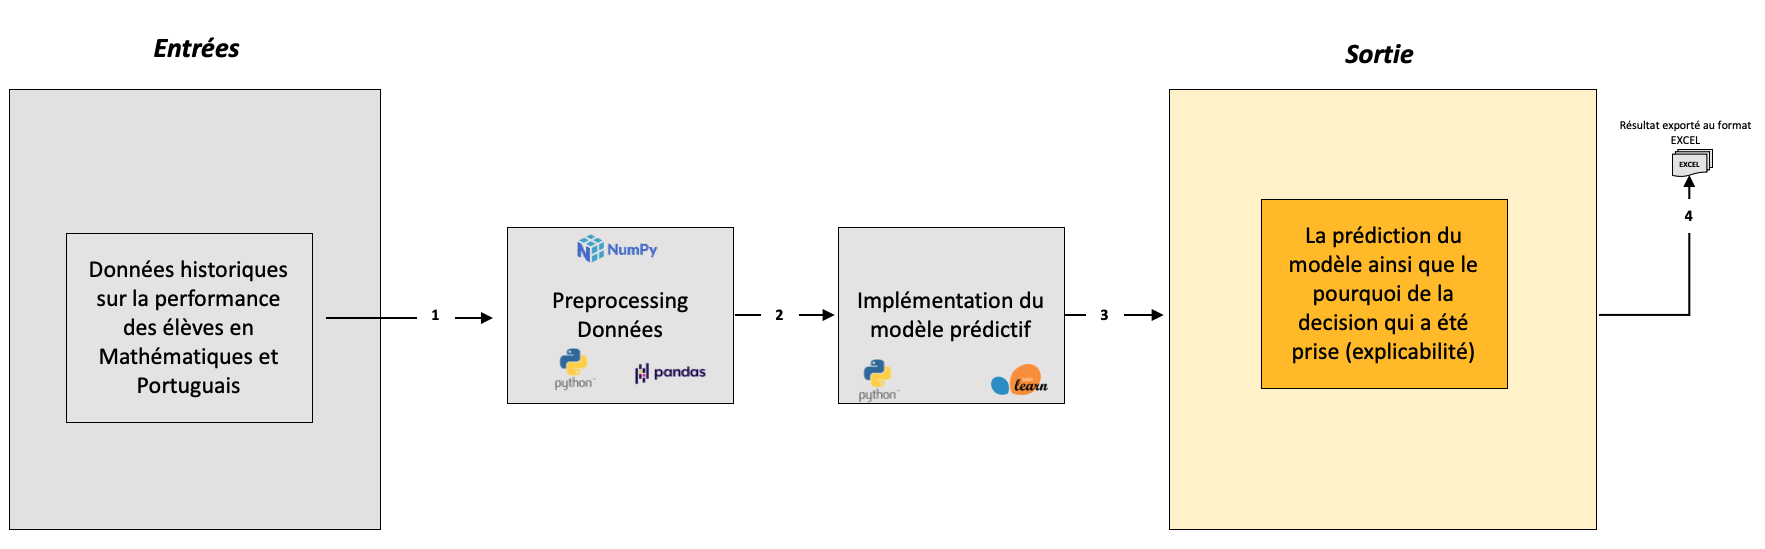

# Résolution     


## Chargement des données     
Source des données : https://archive.ics.uci.edu/ml/datasets/Student+Performance      

In [38]:
# Librairies utilisée pour éviter les warnings
import warnings
warnings.filterwarnings('ignore') 

In [39]:
# Import des libraries importantes
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.util.testing import assert_frame_equal
from lime.lime_tabular import LimeTabularExplainer

In [40]:
student_mat = pd.read_csv("../input/studentperformance/student-mat.csv", sep=";")
student_por = pd.read_csv("../input/studentperformance/student-por.csv", sep=";")

Nous avons deux dataframes dans le repertoire de la source des données. 
- la première correspond aux données en Mathématique   
- la second correspond aux données en Portoguais

## Processing des données

In [41]:
# 1. Format données en Math
print(student_mat.shape)

# 2. Format données en Portuguais
print(student_por.shape)

Les points 1. et 2. montrent respectivement les formats des données **student_mat**, **student_por**. Elles sont toutes de la forme **(L, C)**, avec:   
- **L**: le nombre de lignes    
- **C**: le nombre de colonnes     

Une chose est d'avoir les données, mais une autres d'avoir les données propres, car indispensable pour la bonne résolution du problème proposé. Pour ce faire, nous allons effectuer les actions suivantes:   
- 1. Supprimer les doublons dans la données (en ne gardant qu'une seule instance), s'il y en a  
- 2. Vérifier le % de données manquantes pour chaque colonne dans la donnée. Le but étant de supprimer les colonnes les au moins 50% de données manquantes. Ces 50% peuvent être bien évidemment discuté.       

In [42]:
# Case 1: vérification de doublons
def remove_duplicate(data):
    """
        @desc: 
            - Remove duplicates from data
            
        @params:
            - data: the data set to be analyzed
            
        @return:
            - the final processed data
    """
    print("1. Shape before removing duplicate: {}".format(data.shape))
    data = data.drop_duplicates()
    print("2. Shape after removing duplicate: {}".format(data.shape))
    
    return data

# Cas 2: vérification des pourcentages des données manquantes et suppression selon seuil
def remove_cols_with_missing_data(data, threshold=50):
    """
        @desc: 
            - Drop columns with a given percentage of missing data
            
        @params:
            - data: the data set to be analyzed
            - threshold: the threshold to be considered when droping columns
            
        @return:
            - the final processed data
    """
    percent_missing = data.isnull().sum() * 100 / len(data)
    print("1. % Avant Application Seuil Suppression: \n{}".format(percent_missing))
    
    data = data.dropna( axis=1, thresh = threshold)
    print("\n2. % Après Application Seuil Suppression: \n{}".format(data.isnull().sum() * 100 / len(data)))
    
    return data


# Combinason des deux cas précédents
def preprocess_data(data, threshold = 50):
    """
        @desc: 
            - Remove duplicates and drop columns with a given percentage of missing data
            
        @params:
            - data: the data set to be analyzed
            - threshold: the threshold to be considered when droping columns
            
        @return:
            - the final processed data
    """
    data = remove_duplicate(data)
    
    data = remove_cols_with_missing_data(data, threshold = threshold)
    
    return data


# Montre la correlation entre les colonnes 
def show_correlation(data, my_fig_size = (7,6)):
    """
        @desc: 
            - Shows the correlation matrix
            
        @params:
            - data: the data set to be analyzed
            - my_fig_size: the size of the figures to show
            
        @return:
            - shows the information as described 
    """
    correlations = data.corr()

    plt.figure(figsize = my_fig_size)

    #generate a mask for the upper triangle
    #this is for clearer view of the correlations
    
    mask = np.zeros_like(correlations)
    mask[np.triu_indices_from(mask)] = 1

    #to make chart cleaner, multiply corr df with 100 before passing to the heatmap function
    #pass the format  to a whole number

    sns.heatmap(correlations * 100, cmap='RdBu_r', annot=True, fmt='.0f', mask=mask, cbar = False)
    plt.show()

Pour faciliter l'analyse des données nous allons fusionner les données en une seule données, mais en spécifiant pour chacune, la matière correspondate

In [43]:
def combine_data(data1, data2):
    
    return pd.concat([data1, data2], axis=1)

**A. Cas Des Données En Math**

In [44]:
# Preprocessing des données
student_mat = preprocess_data(student_mat, threshold = 50)

**Observation**:    
Visiblement, nous avons des données car, il n'y a aucun doublons (cas 1) ni aucune donnée manquante (cas 2), chose qui arrive très rarement dans la vie réelle. 
Nous pouvons maintenant procéder à l'analyse exploratoire des données afin de vérifier la qualité statistique des données.     

## Analyse Exploratoire des données     
Nous allons procéder à quelques analyses exploratoire consistant à:   
1. Vérifier les types des différentes colonnes de la donnée    
2. Vérifier la distribution des données numériques   
3. Avoir une idée des la distribution des données catégorielles    
4. Analyser la correlation entre les différentes colonnes de la donnée     

Ces analyses exploratoire permettent également d'avoir une meilleure compréhension de la donnée.   

In [45]:
# 1. Vérifier les types des différentes colonnes de la donnée 
print(student_mat.dtypes)

In [46]:
# 2. Vérifier la distribution des données numériques 
def numerical_data_distribution(data, my_fig_size = [12, 12]):
    """
        @desc: 
            - Shows the distribution of all the numerical attributes in the data 
            
        @params:
            - data: the data set to be analyzed
            - my_fig_size: the size of the figures to show
            
        @return:
            - shows the information as described 
    """ 
    data.hist(figsize = my_fig_size)

    plt.show() 
    
    
# 3. Vérifier les informations sur les données catégorielles
def categorical_data_info(data, my_fig_size = [12, 12]):
    """
        @desc: 
            - Shows the distribution of all the categorical attributes in the data 
            
        @params:
            - data: the data set to be analyzed
            - my_fig_size: the size of the figures to show
            
        @return:
            - shows the information as described 
    """ 
    for feature in data.dtypes[data.dtypes =='object'].index:
        sns.countplot(y = feature, data = data)
        plt.show()
        
        
# 4. Montrer l'information globale
def show_overall_info(data, my_fig_size = [12, 12]):
    """
        @desc: 
            - Shows the distribution of all the attributes in the data 
            
        @params:
            - data: the data set to be analyzed
            - my_fig_size: the size of the figures to show
            
        @return:
            - shows the information as described 
    """ 
    numerical_data_distribution(data, my_fig_size = my_fig_size)
    categorical_data_info(data, my_fig_size = my_fig_size)

In [47]:
show_overall_info(student_mat)

**Analyse du graphique**     
Les variables numériques (affichages verticaux) nous montrent que:   
- Une grande majorité des élèves est agée de 15 à 18 ans       
- Très peu de parents n'ont pas d'éducation scolaire, et une grande majorité a une éducation sécondaire et universitaire.  
- Une très majorité des élèves ont un temps de trajet inférieur à 15 minutes et quelques uns ont un temps de trajet supérieur à 1h   
- La plupart des élèves étudient entre 2 et 5h par semaine et une minorité étudient plus de 10h par semaine     
- La plupart des élèves sont dans un environement familial où ne règnent pas de difficulté en termes de relations ques les uns ont avec les autres. Quelques uns sont dans un environment familial assez toxique    
- Ces élèves ont pour la plupart assez de temps libre en dehors des cours   
- Le niveau de santé est assez bon pour la plupart de ces élèves

Les variables catégorielle (affichages horizontaux) quant à elle sont assez compréhensible. 

In [48]:
show_correlation(student_mat, my_fig_size = (7,6))

Nous constatons qu'il y a une forte correlation entre les notes du premier semestre (G1), du 2 eme semestre (G2) et la note finale (G3) que l'on cherche à déterminer et qui permettra de savoir si l'élève réussie ou pas son année en Mathématiques.  

**A. Cas Des Données En Portuguais**

In [49]:
# Preprocessing des données
student_por = preprocess_data(student_por)

**Notes**:  Les observations sur les données sont identiques à celles relatives aux données sur les Mathématiques   

In [50]:
# Analyse de la distribution des données
show_overall_info(student_por)

De manière analogue à la prédente analyse pour les données numériques. 

In [51]:
show_correlation(student_por, my_fig_size = (7,6))

Nous avons les mêmes analyses de correlation pour les matières en Portuguais que celles en Mathématiques.   

# Construction des modèles d'IA    
L'idée étant d'avoir un outil permettant d'avoir une flexbilité de conseil, il est préférable d'avoir une IA dédiée à chaque matière, à savoir entrainer pour chaque données, le modèle prédictif correspondant. 
Aussi, pour chaque modèle nous avons les scénarios suivants:  

- Cas 1: Prédire la performance (G3) avant la fin du premier semestre
    - Entrainement du modèle sur tous les attributs saut le G1 et G2 car inconnu à priori.  
    
    
- Cas 2: A la fin du premier semestre (ayant G1), prédire la performance (G3) de l'élève   
    - Entrainement du modèles sur tous les attributs saut le G1 (connu mais fortement correlé à G2) et G3 (inconnu à priori) 
    
    
- Cas 2: A la fin du second semestre (ayant G2), prédire la performance (G3) de l'élève   
    - Entrainement du modèles sur tous les attributs saut le G1 (connu mais fortement correlé à G2) 

### Les algorithmes candidats - Fonction d'entrainement et d'évaluation 

In [52]:
# Librairie de séparation des données
from sklearn.model_selection import train_test_split, GridSearchCV

# Librairie d'affichage des métriques
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, \
    confusion_matrix, classification_report, fbeta_score, make_scorer, plot_confusion_matrix

# Les algorithmes testés pour l'entrainement
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
                                GradientBoostingClassifier, AdaBoostClassifier, \
                                GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [53]:
"""
# Classifiers Linéaires
"""
# Candidats
linear_clfs = {'Naive Bayes': GaussianNB(),
               'SVM': SVC()
            }

# Paramètres
params_linear_clfs = {'Naive Bayes': {},
                      'SVM': {
                        'kernel': ['linear','rbf'],
                        'probability': [True]
                            }
                    }


"""
# Classifiers sur methodes d'ensemble
"""
# Candidats
ensbl_clfs = {'Bagging':BaggingClassifier(), 
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier() 
       }

# Parametres
params_ensbl_clfs = {
'Bagging':{
    'n_estimators':[5,10,15],
    'max_samples':[0.5,1.0],
    'bootstrap': [True, False]
}, 

'Decision Tree':{
    'max_depth': list(range(2,20)),
    'criterion': ['gini','entropy'],
    'class_weight':['balanced'],
    'random_state':[0]
}, 
    
'Random Forest': {
    'max_depth': list(range(2, 12)),
    'criterion': ['gini','entropy'],
    'n_estimators': [10, 20, 30, 40],
    'class_weight':['balanced', 'balanced_subsample'],
    'random_state':[0]
}}

In [54]:
# Fonction d'entrainement  
def training_fc(X_train, X_test, y_train, y_test, clfs, params):
    """
        @desc: 
            - Run the training of the model according to the given inputs
            
        @params:
            - X_train: the training data
            - X_test: the testing data
            - y_train: the training label
            - y_test: the testing label
            - clfs: the dictionary of candidate classifiers
            - params: the list of parameters of each classifier
            
        @return:
            - shows the performance during training 
    """ 
    for name, base_clf in clfs.items():
        print('******************** {} ********************'.format(name))
        clf = GridSearchCV(
             base_clf, params[name], n_jobs = 2, cv=10
        )
        clf.fit(X_train, y_train)
        print('Best Params')
        print(clf.best_params_)
        print('Report')
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        plot_confusion_matrix(clf, X_test, y_test)
        plt.show()
        
        
# Fonction d'affichage des paramètres importante
def plot_feature_importance(clf, X_train, y_train, show_top_n=10, is_bag = False):
    """
        @desc: 
            - plot the feature importance for a given classifier
            
        @params:
            - clf: classifier
            - X_train: the training data
            - y_train: training label
            - is_bag: used to check if the classifier is BaggingClassifier or not
            
        @return:
            - feature importance as plot
    """

    # Obtain the feature importance
    
    if(is_bag):
        if(str(type(clf)) == str("<class 'sklearn.ensemble._bagging.BaggingClassifier'>")):
            
            feature_importances = np.mean([
                    tree.feature_importances_ for tree in clf.estimators_
                ], axis=0)
            
    else:
        feature_importances = clf.feature_importances_
            
        
    feature_importance = pd.DataFrame(feature_importances,
                                       index = X_train.columns,
                                       columns=['Variable_Importance']).sort_values('Variable_Importance',
                                                                                    ascending=True).tail(show_top_n)
    # Set seaborn contexts 
    sns.set(style="whitegrid")

    feature_importance.plot.barh(figsize=(15,10))
    
    
def create_explainer(df, X_train, label_colums_name):
    """
        @desc: 
            - Create the explainer corresponding from a given training dataset
            
        @params:
            - df: the original data set containing the unprocessed target column names
            - df_ml: The preprocessed training data
            - label_colums_name: the column corresponding to the labels
            
        @return:
            - the explainer 
    """    
    
    cols = list(df.columns)
    cols.remove(label_colums_name)
    target_names = list(df[label_colums_name].unique())
    cols = df

    explainer = LimeTabularExplainer(X_train.values, feature_names=cols, discretize_continuous=True, 
                                     class_names=target_names)
    
    return explainer

## 1. Pour les Mathématiques     

### Création des données d'entrainement    
Nous allons créer les données et faire en sorte que le G3 soit sous le format ci-dessous:   
- L'élève réussi si G3>=10 ==> Label G3=0
- L'élève echou sinon ==> Label G3=1

In [55]:
def encode_target(value, threshold=10):
    """
        @desc: 
            - Return a binary value depending on a given value 
            
        @params:
            - value: the G3 value to be analyzed
            - threshold: the threshold that determines if the G3 value should be 0 or 1
            
        @return:
            - 0 or 1 
    """ 
    if(value >= threshold):
        return 0
    else:
        return 1
    
def perform_feature_engineering(data):
    """
        @desc: 
            - Transform the G3 into a binary value (0 or 1) and encode all the categorical features
            
        @params:
            - data: the data to be analyzed
            
        @return:
            - the preprocessed data
    """     
    # encode G3 column
    data.G3 = data.G3.apply(encode_target)
    
    # Transform categorical features
    data = pd.get_dummies(data)
    
    return data

In [56]:
# Lancer le feature engineering
student_mat = perform_feature_engineering(student_mat)

In [57]:
# La valeur G3 du premier élève
student_mat.iloc[0]['G3']

In [58]:
# Encoder les varibles catégorielle
student_mat = pd.get_dummies(student_mat)

'''
# Cas n°1 :  Prédire la performance avant la fin du premier semestre (G1)
'''
# Recupérer les données d'entrainement et de test
y_g3 = student_mat.G3
X_before_g1 = student_mat.drop(['G2', 'G3', 'G1'], axis = 1)


'''
# Cas 2: A la fin du premier semestre (ayant G1), prédire la performance (G3) de l'élève 
'''
X_before_g2 = student_mat.drop(['G2', 'G3'], axis = 1)


'''
# Cas 2: A la fin du premier semestre (ayant G1), prédire la performance (G3) de l'élève 
'''
X_after_g2 = student_mat.drop(['G1', 'G3'], axis = 1)

**Note**: Vu la taille des données globales, mieux vaut éviter les algorithmes d'apprentissage profond, car on n'aura pas de bonnes performances avec celles-ci.    

### Entrainement sur le cas 1    
Pour des raisons de temps, nous allons nous limiter à ce premier cas pour les Mathématiques

In [59]:
# Création des données d'entrainement et de test (80% pour l'entrainement et 20% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X_before_g1, y_g3, test_size=0.2, stratify= y_g3, random_state=2022)

# Lancement de l'entrainement sur les classifiers linéaires
training_fc(X_train, X_test, y_train, y_test, linear_clfs, params_linear_clfs)

In [60]:
# Lancement de l'entrainement sur les modèles d'ensemble
training_fc(X_train, X_test, y_train, y_test, ensbl_clfs, params_ensbl_clfs)

### Choix du meilleur modèle et son explication    
Plusieurs modèles ont été évalué, mais le meilleur parmis eux est le **Bagging** car il est celui avec la plus grande valeur de f1 score comme indiqué par le rapport de classification ci-dessous: 

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        53
           1       0.62      0.38      0.48        26

    accuracy                           0.72        79
   macro avg       0.69      0.64      0.64        79
weighted avg       0.71      0.72      0.70        79


Les meilleurs paramètres ayant permi l'obtention de cette valeur de f1 score sont les suivantes:         
***{'bootstrap': True, 'max_samples': 0.5, 'n_estimators': 15}***  
Nous pouvons enfin initialiser le modèle avec ces valeurs pour ensuite avoir les informations suivantes:    
- Les paramètres important ayant influancé la décision du modèle    
- L'explicabilité du modèle: facteur très important pour créer la confiance sur les décisions faites par le modèle.     

#### Affichage des variables importantes    
L'objectif ici est d'afficher les 10 meilleures variavles les plus importantes pour la prises de décision du modèle

In [61]:
# Initialisation du modèle
model_bagging = BaggingClassifier(bootstrap = True, max_samples = 0.5, n_estimators = 15)
model_bagging.fit(X_train, y_train)

# Montrer les variables importantes
plot_feature_importance(model_bagging, X_train, y_train, is_bag=True)

D'après le modèle relatif aux données en Mathématiques, les variables qui influencent la prise de décision du modèles sont celles montrées ci-dessus.  
- par exemple, la variable failure correspondant au nombre d'échecs historique est celle qui le plus d'effet sur la prise de décision du modèle. C'est à dire qu'un(e) élève qui comptabilise beaucoup d'échec antérieurs aura tendance à échouer encore dans le future.  

Dans notre cas, seules les 10 variables les plus importantes ont été montrées

#### Explicabilité du modèle

In [28]:
# Créer le module d'explicabilité
bagging_explainer = create_explainer(student_mat, X_train, 
                                     'G3')

# Expliquer une instance 
bagging_explainer.explain_instance(X_test.iloc[0, :], 
                                       model_bagging.predict_proba, 
                                       top_labels=1).show_in_notebook()

Sur ce graphique, nous avons:  
- A gauche: les prédictions du modèle ainsi que son explication    
- A droite: les valeurs réelles pour cet élève    

Ici, on voit que le modèle prédit que l'élève échoue en donnant les raisons de sa prise de décision:     
- Niveau de confiance: 80%    
- Pourquoi il/elle échoue: 
    - parce que nombre d'absences > 8  
    - parce que les parents sont séparés: ce qui cré peut être autant d'absence, parce qu'il doit passer du temps avec chacun des parents ne résident pas au même endroit?   
    - pourtant la relation familiale est bonne. Ce qui est à mon avis logique, sinon, l'enfant serait uniquement chez un seul parent.

## 2. Pour le Portuguais         

Le processus d"entrainement, de génération des variables importantes et de lancement de l'explicabilité seront les mêmes dans cette phase.   

In [62]:
# Lancer le feature engineering
student_por = perform_feature_engineering(student_por)

In [63]:
# La valeur G3 du premier élève
student_por.iloc[0]['G3']

In [64]:
'''
# Cas n°1 :  Prédire la performance avant la fin du premier semestre (G1)
'''
# Recupérer les données d'entrainement et de test
y_g3 = student_por.G3
X_before_g1 = student_por.drop(['G2', 'G3', 'G1'], axis = 1)

In [65]:
# Création des données d'entrainement et de test (80% pour l'entrainement et 20% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X_before_g1, y_g3, test_size=0.2, stratify= y_g3, random_state=2022)

In [66]:
# Lancement de l'entrainement sur les classifiers linéaires
training_fc(X_train, X_test, y_train, y_test, linear_clfs, params_linear_clfs)

In [34]:
# Lancement de l'entrainement sur les modèles d'ensemble
training_fc(X_train, X_test, y_train, y_test, ensbl_clfs, params_ensbl_clfs)

### Choix du meilleur modèle et son explication    
Le meilleur parmis eux est le **Bagging** car il est celui avec la plus grande valeur de f1 score comme indiqué par le rapport de classification ci-dessous 

             precision    recall  f1-score   support

           0       0.95      0.79      0.86       110
           1       0.39      0.75      0.52        20

    accuracy                           0.78       130
   macro avg       0.67      0.77      0.69       130
weighted avg       0.86      0.78      0.81       130

Les meilleurs paramètres sont les suivants:     
**{'bootstrap': True, 'max_samples': 1.0, 'n_estimators': 10}**

#### Affichage des variables importantes    
Toujours dans la même dynamique que précédemment, l'objectif ici est d'afficher les 10 meilleures variavles les plus importantes pour la prises de décision du modèle

In [68]:
model_bagging = BaggingClassifier(bootstrap = True, max_samples = 1.0, n_estimators = 10)
model_bagging.fit(X_train, y_train)

# Montrer les variables importantes
plot_feature_importance(model_bagging, X_train, y_train, is_bag=True)

Nous pouvons par la même logique d'analyse sur les données des Mathématiques comprendre le précédent résultat. 

#### Explicabilité du modèle   

In [69]:
# Créer le module d'explicabilité
bagging_explainer = create_explainer(student_por, X_train, 
                                     'G3')

# Expliquer une instance 
bagging_explainer.explain_instance(X_test.iloc[0, :], 
                                       model_bagging.predict_proba, 
                                       top_labels=1).show_in_notebook()

La prédiction faite est que l'élève n'echoue pas avec 100% de confiance. On voit ici que l'explication du modèle peut être remise en cause, ce qui est un moyen très pertinant de créer de la transparance.

## 

## Conclusion   
Avec toutes les analyses précédemment effectuées. Nous avons non seulement montré la faisabilité du projet mais aussi son implémentation de bout en bout.   
Une valeur ajouté de cette solution est qu'elle permettra aux utilisateurs de prendre des décisions de manière guidée grâce à la fonctionalité d'explicabilité apportée par l'outil, tout en créant de la transparance.     
La prochaine étape serait de convaincre le Ministère de la pertinance de notre outils, à l'aide d'un prototype  et enfin intégrer la solution dans le système des deux écoles pilotes pour valider sa pertinance afin d'effectuer sa montée à l'échelle en le proposant au plan national.     